In [1]:
# data munging and visualization
import numpy as np
import pandas as pd
import itertools


# class imbalance treatment
from imblearn.over_sampling import SMOTE
from sklearn.utils import resample


# visualization
import matplotlib.pyplot as plt
%matplotlib inline


# feature engineering
import featuretools as ft


# predictor -> classification, regression
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.metrics import f1_score


# miscellanous
import datetime
import os

# external functions
import utils

# Non-parallelized

## Users

In [2]:
# users = pd.read_csv('data/users_Feb_1_30days_cohort.csv')
users = pd.read_csv('data/users_1y_6mCustomerValue.csv')
users['bux_account_created_dts'] = pd.to_datetime(users['bux_account_created_dts'])
users = users[users.columns[1:]]
len(users)

565983

In [3]:
len(users.columns)

11

In [4]:
users['month_year'] = users['bux_account_created_dts'].apply(lambda x: x.strftime('%B-%Y'))

In [5]:
def calculate_cohort_limit(users, ratio):
    cohort_limit_df = pd.DataFrame(users.groupby("month_year").count()["user_id"]).reset_index()
    cohort_limit_df.columns = [["month_year", "count"]]
    cohort_limit_df["count/10"] = (cohort_limit_df["count"] / ratio).astype(int)
    return cohort_limit_df

In [7]:
cohort_limit_df = utils.calculate_cohort_limit(users)
cohort_limit_df

,month_year,count,count/n
0,April-2017,48021,4802
1,August-2017,61159,6115
2,December-2016,25398,2539
3,February-2017,56861,5686
4,January-2017,53645,5364
5,July-2017,42778,4277
6,June-2017,34251,3425
7,March-2017,62328,6232
8,May-2017,35330,3533
9,November-2016,45996,4599


In [8]:
sampled_users = utils.limit_users(cohort_limit_df, users, cohort_limit_df["month_year"][0])

In [10]:
sampled_users = pd.DataFrame()


for month_year in cohort_limit_df["month_year"][0:]:
    sampled_users = sampled_users.append(utils.limit_users(cohort_limit_df, users, month_year))
    
len(sampled_users)

56593

In [11]:
users = sampled_users
users.reset_index(inplace=True,drop=True)
users.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,ams_first_funded_dts,initial_deposit_amount,month_year
0,00210d1f-ba50-47ae-8c4c-7e8f3b913696,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-04-29 20:41:15.804,NaN,NaN,April-2017
1,00a56f5b-3306-4709-a183-a6084ec00875,AT,MALE,AT,Android,NONE,Rookie Trader,Facebook Installs,2017-04-25 15:06:08.110,NaN,NaN,April-2017
2,01346dc4-12a6-4335-837d-c57982561d81,AT,NaN,NaN,Android,NONE,Rookie Trader,TV,2017-04-24 12:51:40.771,NaN,NaN,April-2017
3,056f2077-d594-4529-a57f-1c2cfa6a3732,AT,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-04-19 22:12:35.936,NaN,NaN,April-2017
4,065a5cfe-b30e-4279-abfe-f3dcab3e7856,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-04-24 11:46:59.534,NaN,NaN,April-2017


In [12]:
# sample_users = False
# sample_num = 30000

# if sample_users:
#     users = users[0:sample_num]

# len(users)

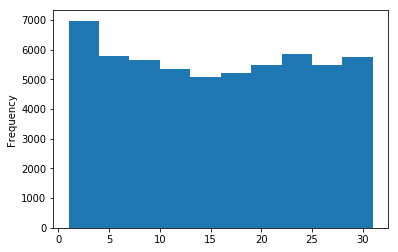

In [13]:
users['bux_account_created_day'] = [ts.day for ts in users['bux_account_created_dts']]
users['bux_account_created_day'].plot(kind='hist');

## Cube daily user

In [14]:
# transactions = pd.read_csv('data/cube_daily_user_Feb_1_30days_cohort.csv')
transactions = pd.read_csv('data/cube_1y_6mCustomerValue.csv')
transactions['date'] = pd.to_datetime(transactions['date'])
transactions = transactions[transactions.columns[1:]]
transactions.head()

,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
0,db8f1a76-1cd5-46cb-a866-bef8b0e631f2,275,2016-10-01,4,368,FUN_BUX,0,0.00,0,Non-Social,0
1,db8fb559-e911-4437-8fed-87508d85e4a4,311,2016-11-06,1,287,FUN_BUX,0,0.00,0,Non-Social,0
2,db8fb559-e911-4437-8fed-87508d85e4a4,312,2016-11-07,1,194,FUN_BUX,0,0.00,0,Non-Social,0
3,db8fe7d1-141e-4643-978c-2695e96aab29,309,2016-11-04,3,376,FUN_BUX,2,1.16,0,Non-Social,0
4,db8fe7d1-141e-4643-978c-2695e96aab29,316,2016-11-11,0,0,FUN_BUX,0,0.00,0,Non-Social,0


In [15]:
len(transactions), len(transactions['user_id'].unique()), len(transactions.columns)

(3332705, 552755, 11)

In [16]:
transactions = transactions[transactions['user_id'].isin(users['user_id'])]
# transactions = transactions[transactions.columns[1:]]
transactions.reset_index(inplace=True,drop=True)
transactions.reset_index(inplace=True)
transactions.rename(columns={'index': 'transaction_id'}, inplace=True)
len(transactions), len(transactions["user_id"].unique())

(352693, 55665)

In [17]:
transactions.head()

,transaction_id,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
0,0,dbba42b5-b26a-4435-9b3e-8bbc671779cd,306,2016-11-01,2,152,FUN_BUX,0,0.00,0,Non-Social,0
1,1,36d45205-9bc3-441b-9c32-c8e9e3d69999,314,2016-11-09,3,580,FUN_BUX,1,0.00,0,Non-Social,0
2,2,36d45205-9bc3-441b-9c32-c8e9e3d69999,315,2016-11-10,36,22691,SERIOUS_BUX,1,54.36,0,Non-Social,1
3,3,36d45205-9bc3-441b-9c32-c8e9e3d69999,316,2016-11-11,40,64388,SERIOUS_BUX,0,0.00,0,Non-Social,0
4,4,36d45205-9bc3-441b-9c32-c8e9e3d69999,317,2016-11-12,5,445,SERIOUS_BUX,0,0.00,0,Non-Social,0


## Target values (Current customer value - CurCV)

In [18]:
# CurCV = pd.read_csv('data/curCv_Feb_1_30days_cohort.csv')
CurCV = pd.read_csv('data/curcv_1y_6mCustomerValue.csv')
CurCV["curcv"] = CurCV["com"] + CurCV["ff"]
CurCV = CurCV[['user_id', 'curcv']]
CurCV = CurCV.fillna(0)
CurCV.head()

,user_id,curcv
0,00001025-a69f-498c-be1e-6fc4ec96453b,0.0
1,000089cb-93b4-4f7e-b483-a40585c2f6c8,0.0
2,00020daa-71ab-4c8f-ac25-3eaa5ba2cc53,0.0
3,0003900f-c8f6-41b0-8ed7-36b8b2f6eb19,0.0
4,0003db40-1f04-4a05-a20a-b636b10aaf62,0.0


In [19]:
len(users)

56593

In [20]:
len(CurCV)

565983

In [21]:
CurCV["curcv"].describe()

count    565983.000000
mean          4.394384
std         138.806792
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max       30432.380000
Name: curcv, dtype: float64

In [22]:
CurCV = CurCV[CurCV['user_id'].isin(users['user_id'])]
CurCV.reset_index(drop=True,inplace=True)
len(CurCV) == len(users)

True

## Define entities, entity tables and relationships

In [23]:
users[0:5]

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,ams_first_funded_dts,initial_deposit_amount,month_year,bux_account_created_day
0,00210d1f-ba50-47ae-8c4c-7e8f3b913696,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-04-29 20:41:15.804,NaN,NaN,April-2017,29
1,00a56f5b-3306-4709-a183-a6084ec00875,AT,MALE,AT,Android,NONE,Rookie Trader,Facebook Installs,2017-04-25 15:06:08.110,NaN,NaN,April-2017,25
2,01346dc4-12a6-4335-837d-c57982561d81,AT,NaN,NaN,Android,NONE,Rookie Trader,TV,2017-04-24 12:51:40.771,NaN,NaN,April-2017,24
3,056f2077-d594-4529-a57f-1c2cfa6a3732,AT,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-04-19 22:12:35.936,NaN,NaN,April-2017,19
4,065a5cfe-b30e-4279-abfe-f3dcab3e7856,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-04-24 11:46:59.534,NaN,NaN,April-2017,24


In [24]:
transactions[0:5]

,transaction_id,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
0,0,dbba42b5-b26a-4435-9b3e-8bbc671779cd,306,2016-11-01,2,152,FUN_BUX,0,0.00,0,Non-Social,0
1,1,36d45205-9bc3-441b-9c32-c8e9e3d69999,314,2016-11-09,3,580,FUN_BUX,1,0.00,0,Non-Social,0
2,2,36d45205-9bc3-441b-9c32-c8e9e3d69999,315,2016-11-10,36,22691,SERIOUS_BUX,1,54.36,0,Non-Social,1
3,3,36d45205-9bc3-441b-9c32-c8e9e3d69999,316,2016-11-11,40,64388,SERIOUS_BUX,0,0.00,0,Non-Social,0
4,4,36d45205-9bc3-441b-9c32-c8e9e3d69999,317,2016-11-12,5,445,SERIOUS_BUX,0,0.00,0,Non-Social,0


In [25]:
CurCV.head()

,user_id,curcv
0,000089cb-93b4-4f7e-b483-a40585c2f6c8,0.0
1,0003db40-1f04-4a05-a20a-b636b10aaf62,0.0
2,0005422d-14c7-4381-a9cc-c8516e2dfbf8,0.0
3,0006ae6e-0036-4ccd-bf05-16aeb5271d17,0.0
4,0007c175-df3c-41d3-b1c3-04f62579e954,0.0


In [26]:
es = ft.EntitySet("bux_cltv")

In [27]:
es.entity_from_dataframe(entity_id='users',
                        dataframe=users,
                        index='user_id',
                        time_index='bux_account_created_dts')

Entityset: bux_cltv
  Entities:
    users (shape = [56593, 13])
  Relationships:
    No relationships

In [28]:
es.entity_from_dataframe(entity_id='transactions',
                        dataframe=transactions,
                        index='transaction_id',
                        time_index='date')

Entityset: bux_cltv
  Entities:
    transactions (shape = [352693, 12])
    users (shape = [56593, 13])
  Relationships:
    No relationships

In [29]:
es.add_relationship(ft.Relationship(es['users']['user_id'], es['transactions']['user_id']))

Entityset: bux_cltv
  Entities:
    transactions (shape = [352693, 12])
    users (shape = [56593, 13])
  Relationships:
    transactions.user_id -> users.user_id

In [30]:
users.head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,ams_first_funded_dts,initial_deposit_amount,month_year,bux_account_created_day
0,00210d1f-ba50-47ae-8c4c-7e8f3b913696,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-04-29 20:41:15.804,NaN,NaN,April-2017,29
1,00a56f5b-3306-4709-a183-a6084ec00875,AT,MALE,AT,Android,NONE,Rookie Trader,Facebook Installs,2017-04-25 15:06:08.110,NaN,NaN,April-2017,25
2,01346dc4-12a6-4335-837d-c57982561d81,AT,NaN,NaN,Android,NONE,Rookie Trader,TV,2017-04-24 12:51:40.771,NaN,NaN,April-2017,24
3,056f2077-d594-4529-a57f-1c2cfa6a3732,AT,NaN,NaN,Android,NONE,Rookie Trader,Viral Invites,2017-04-19 22:12:35.936,NaN,NaN,April-2017,19
4,065a5cfe-b30e-4279-abfe-f3dcab3e7856,AT,NaN,NaN,Android,NONE,Rookie Trader,Organic,2017-04-24 11:46:59.534,NaN,NaN,April-2017,24


# Parallelized (Dask)

In [5]:
def load_entity_set(data_dir):
    
    user_details = pd.read_csv(os.path.join(data_dir, "user_details.csv"))
    user_details['month_year'] = user_details['bux_account_created_dts'].apply(lambda x: x.strftime('%B-%Y'))
    
    daily_transactions = pd.read_csv(os.path.join(data_dir, "daily_transactions.csv"))
    daily_transactions['date'] = pd.to_datetime(daily_transactions['date'])
    daily_transactions = daily_transactions[daily_transactions.columns[1:]]
    daily_transactions = daily_transactions[daily_transactions['user_id'].isin(users['user_id'])]
    daily_transactions.reset_index(inplace=True,drop=True)
    daily_transactions.reset_index(inplace=True)
    daily_transactions.rename(columns={'index': 'transaction_id'}, inplace=True)

    curcv = pd.read_csv(os.path.join(data_dir, "curcv.csv"))
    
        
    es = ft.EntitySet("bux_cltv")
    
    es.entity_from_dataframe(entity_id='users',
                        dataframe=user_details,
                        index='user_id',
                        time_index='bux_account_created_dts')
    
    es.entity_from_dataframe(entity_id='transactions',
                        dataframe=daily_transactions,
                        index='transaction_id',
                        time_index='date')
    
    es.add_relationship(ft.Relationship(es['users']['user_id'], es['transactions']['user_id']))
    
    
    return es

In [3]:
es = utils.load_entity_set("data/partitioned_data/part_1/")
es

Entityset: bux_cltv
  Entities:
    transactions (shape = [70618, 12])
    users (shape = [10194, 13])
  Relationships:
    transactions.user_id -> users.user_id

In [4]:
from dask import bag
from dask.diagnostics import ProgressBar

pbar = ProgressBar()
pbar.register()

In [5]:
path = "data/partitioned_data/"
_, dirnames, _ = os.walk(path).__next__()
dirnames = [path+d for d in dirnames]
b = bag.from_sequence(dirnames)
entity_sets = b.map(utils.load_entity_set)

In [6]:
labels = entity_sets.map(utils.make_labels)
labels

dask.bag<map-mak..., npartitions=4>

In [7]:
# load in the features from before
# top_features = ft.load_features("top_features", es)

feature_matrices = labels.map(utils.calculate_feature_matrix) # , features=top_features)

In [8]:
fms_out = feature_matrices.compute()
X = pd.concat(fms_out)

Building features: 65it [00:00, 1052.00it/s]
Building features: 65it [00:00, 1421.54it/s]
Building features: 65it [00:00, 2341.01it/s]
Building features: 65it [00:00, 1505.14it/s]
[                                        ] | 0% Completed |  5min 13.6s
49 features generated
Progress: 100%|██████████| 1/1 [05:10<00:00, 310.70s/cutoff time]
[##########                              ] | 25% Completed |  5min 52.9s49 features generated
Progress: 100%|██████████| 1/1 [06:30<00:00, 390.94s/cutoff time]
[####################                    ] | 50% Completed |  7min 37.1s49 features generated
Progress: 100%|██████████| 1/1 [10:17<00:00, 617.02s/cutoff time]
[##############################          ] | 75% Completed | 12min 56.8s49 features generated
[########################################] | 100% Completed | 13min  5.7s


In [10]:
len(X)

95829

In [16]:
temp_df = pd.read_csv("data/1y_6mCustomerValue.csv").head()

In [ ]:
# CurCV = pd.read_csv('data/curCv_Feb_1_30days_cohort.csv')
CurCV = pd.read_csv('data/curcv_1y_6mCustomerValue.csv')
CurCV["curcv"] = CurCV["com"] + CurCV["ff"]
CurCV = CurCV[['user_id', 'curcv']]
CurCV = CurCV.fillna(0)
CurCV.head()

In [ ]:
# target values - current customer value
labels = curcv = pd.read_csv(os.path.join(data_dir, "curcv.csv"))
labels = curcv[curcv['user_id'].isin(distinct_users)]

In [ ]:
feature_matrices = label_times.map(utils.calculate_feature_matrix, features=top_features)

## Building labels

In [34]:
# rebalancing (R), visualization
# https://shiring.github.io/machine_learning/2017/04/02/unbalanced

- #### First, we'll separate observations from each class into different DataFrames.
- #### Next, we'll resample the minority class with replacement, setting the number of samples to match that of the majority class.
- #### Finally, we'll combine the up-sampled minority class DataFrame with the original majority class DataFrame.

In [31]:
# 70 euros 1 year customer value-> a user whale or not whale
whale_threshold = CurCV['curcv'].quantile(0.99)
whale_threshold

48.41200000000026

In [32]:
CurCV['whale'] = (CurCV['curcv'] > whale_threshold).astype(int)
CurCV['whale'].value_counts()

0    56027
1      566
Name: whale, dtype: int64

In [33]:
# CurCV
CurCV['curcv'].mean(), CurCV['curcv'].median()

(5.070059194600033, 0.0)

In [34]:
# cohort value
CurCV['curcv'].sum()

286929.85999999964

In [35]:
# max value
CurCV['curcv'].max()

9435.0599999999995

In [36]:
CurCV.head()

,user_id,curcv,whale
0,000089cb-93b4-4f7e-b483-a40585c2f6c8,0.0,0
1,0003db40-1f04-4a05-a20a-b636b10aaf62,0.0,0
2,0005422d-14c7-4381-a9cc-c8516e2dfbf8,0.0,0
3,0006ae6e-0036-4ccd-bf05-16aeb5271d17,0.0,0
4,0007c175-df3c-41d3-b1c3-04f62579e954,0.0,0


In [37]:
len(CurCV[CurCV["user_id"] == "70c15a3e-b516-4aca-bea2-aa909a4a16d2"])

0

In [38]:
# # Separate majority and minority classes
# CurCV_majority = CurCV[CurCV["whale"] == 0 ]
# CurCV_minority = CurCV[CurCV["whale"] == 1 ]
 
# # Upsample minority class
# CurCV_minority_upsampled = resample(CurCV_minority, 
#                                  replace=True,     # sample with replacement
#                                  n_samples=len(CurCV[CurCV["whale"] == 0]),    # to match majority class
#                                  random_state=123) # reproducible results
 
# # Combine majority class with upsampled minority class
# CurCV_upsampled = pd.concat([CurCV_majority, CurCV_minority_upsampled])
 
# # Display new class counts
# CurCV_upsampled["whale"].value_counts()

In [39]:
# len(CurCV_upsampled[CurCV_upsampled["user_id"] == "70c15a3e-b516-4aca-bea2-aa909a4a16d2"])

In [40]:
# CurCV['whale'].plot(kind='bar')

- Training window = the amount of historical data we want to use when calculating features
- cutoff_time = the point in time to calculate the features

We use cutoff times to avoid the risk of leaking labels into prediction

In [41]:
# transactions sorted by the date
trans = es['transactions'].df
trans['date'][0:5]

transaction_id
2399   2016-10-01
4311   2016-10-01
4579   2016-10-01
5874   2016-10-01
5877   2016-10-01
Name: date, dtype: datetime64[ns]

## Automated feature engineering

In [42]:
es['users'].head()

,user_id,country_cd,gender,nationality,platform_type_name,trading_experience,title,network,bux_account_created_dts,ams_first_funded_dts,initial_deposit_amount,month_year,bux_account_created_day
user_id,,,,,,,,,,,,,
13811ce2-4166-40e1-92ea-657e30e4c48e,13811ce2-4166-40e1-92ea-657e30e4c48e,DE,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2016-10-01 00:23:47.153,NaT,NaN,2016-10-01,1
466b8225-19f2-4cba-9680-1b74274da251,466b8225-19f2-4cba-9680-1b74274da251,DE,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2016-10-01 00:25:35.654,NaT,NaN,2016-10-01,1
128c4f3c-25f3-4d22-aa10-c416efd3aefa,128c4f3c-25f3-4d22-aa10-c416efd3aefa,DE,MALE,DE,Android,SOME,Experienced Trader,Organic,2016-10-01 01:36:49.294,NaT,NaN,2016-10-01,1
2ec93ee9-c6b4-4d73-88d5-690f90d192a6,2ec93ee9-c6b4-4d73-88d5-690f90d192a6,DE,NaN,NaN,Android,SOME,Experienced Trader,Facebook Installs,2016-10-01 01:46:35.980,NaT,NaN,2016-10-01,1
22554ec3-5b03-4978-9534-40cc6c973140,22554ec3-5b03-4978-9534-40cc6c973140,DE,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2016-10-01 04:45:02.741,NaT,NaN,2016-10-01,1
0bf22723-3ff5-4088-be4b-b27e6589f40d,0bf22723-3ff5-4088-be4b-b27e6589f40d,DE,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2016-10-01 05:37:31.257,NaT,NaN,2016-10-01,1
53300836-3b2d-4f63-8f55-b9a6d104df1d,53300836-3b2d-4f63-8f55-b9a6d104df1d,DE,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2016-10-01 05:47:28.379,NaT,NaN,2016-10-01,1
1c2afe81-e81e-43a8-8a2a-32a143dfb337,1c2afe81-e81e-43a8-8a2a-32a143dfb337,AT,NaN,NaN,Android,NONE,Rookie Trader,Facebook Installs,2016-10-01 06:38:50.098,NaT,NaN,2016-10-01,1
0378e91d-8e94-47fd-942a-8bb4662bb693,0378e91d-8e94-47fd-942a-8bb4662bb693,DE,NaN,NaN,Android,SOME,Experienced Trader,Viral Invites,2016-10-01 06:45:54.523,NaT,NaN,2016-10-01,1


In [43]:
es['transactions'].head()

,transaction_id,user_id,day_of_year,date,number_of_sessions,total_session_duration,account_status,trades_fb_commodities_open,trades_fb_commodities_profit,social_status_battles,social_status,conversion_to_sb
transaction_id,,,,,,,,,,,,
2399,2399,3800ff41-49e8-4476-a02b-c798eb0673ec,275,2016-10-01,1,240,FUN_BUX,0,0.0,0,Non-Social,0
4311,4311,0378e91d-8e94-47fd-942a-8bb4662bb693,275,2016-10-01,1,191,FUN_BUX,0,0.0,0,Non-Social,0
4579,4579,39703849-377f-4236-ae73-834e0607d8aa,275,2016-10-01,1,314,FUN_BUX,0,0.0,0,Non-Social,0
5874,5874,03d7e40b-2db8-47f3-981f-6ab88844f42d,275,2016-10-01,2,281,FUN_BUX,0,0.0,0,Non-Social,0
5877,5877,03d8f46a-442f-414b-8580-388070372c21,275,2016-10-01,2,87,FUN_BUX,0,0.0,0,Non-Social,0
6180,6180,3de0f083-b92e-4611-8f42-ec492ab99466,275,2016-10-01,2,234,FUN_BUX,0,0.0,0,Non-Social,0
6864,6864,e04a2b04-eaa8-4d1d-8a9f-9688413e0d17,275,2016-10-01,1,275,FUN_BUX,0,0.0,0,Non-Social,0
7083,7083,3bd246c5-46ef-48bf-8d8e-e605cfcfdb70,275,2016-10-01,4,1058,FUN_BUX,0,0.0,0,Non-Social,0
7160,7160,3c07f923-b48c-487f-b377-6fc91bd3705c,275,2016-10-01,2,115,FUN_BUX,0,0.0,2,Chatting,0


In [44]:
from dask import bag
from dask.diagnostics import ProgressBar

In [45]:
# %%time

# from featuretools.primitives import (Sum, Std, Max, Min, Mean,
#                                      Count, PercentTrue, NUnique, 
#                                      Mode, Trend, Skew)


# agg_primitives = [Sum, Std, Max, Min, Mean, 
#                   Count, PercentTrue, NUnique, 
#                   Mode, Trend, Skew]

# feature_matrix, features = ft.dfs(
#     entityset=es,
#     target_entity="users",
#     trans_primitives=[],
#     agg_primitives=agg_primitives,
#     max_depth=3,
#     # cutoff_time=cutoff_times,
#     verbose=True
# )

# print("{} features generated".format(len(features)))

In [46]:
# %%time

# from featuretools.primitives import (Sum, Std, Max, Min, Mean,
#                                      Count, PercentTrue, NUnique, 
#                                      Mode, Trend, Skew)


# agg_primitives = [Sum, Std, Max, Min, Mean, 
#                   Count, PercentTrue, NUnique, 
#                   Mode]

# feature_matrix, features = ft.dfs(
#     entityset=es,
#     target_entity="users",
#     trans_primitives=[],
#     agg_primitives=agg_primitives,
#     max_depth=3,
#     # cutoff_time=cutoff_times,
#     verbose=True
# )

# print("{} features generated".format(len(features)))

In [47]:
%%time

from featuretools.primitives import (Sum, Std, Max, Min, Mean,
                                     Count, PercentTrue, NUnique, 
                                     Mode, Trend, Skew)


agg_primitives = [Sum, Std, Max, Min, Mean, 
                  Count, PercentTrue, NUnique, 
                  Mode]

feature_matrix, features = ft.dfs(
    entityset=es,
    target_entity="users",
    trans_primitives=[],
    agg_primitives=agg_primitives,
    max_depth=2,
    # cutoff_time=cutoff_times,
    verbose=True
)

print("{} features generated".format(len(features)))

Building features: 65it [00:00, 4372.36it/s]
Progress: 100%|██████████| 1/1 [23:42<00:00, 1422.45s/cutoff time]
49 features generated
CPU times: user 22min 40s, sys: 5.28 s, total: 22min 45s
Wall time: 23min 43s


In [54]:
len(feature_matrix)

56593

In [53]:
type(features_encoded[0])

featuretools.primitives.binary_transform.Equals

In [48]:
# encode categorical features
fm_encoded, features_encoded = ft.encode_features(feature_matrix, features)


print('Number of features %s' % len(features_encoded))
fm_encoded.head()

Number of features 95


,title = Rookie Trader,title = Experienced Trader,title = Pro Trader,title = Channel Owner,title = PRO Trader,title = BUX Editor,title = unknown,trading_experience = NONE,trading_experience = SOME,trading_experience = EXPERT,...,MODE(transactions.social_status) = Chatting,MODE(transactions.social_status) = unknown,STD(transactions.conversion_to_sb),STD(transactions.day_of_year),MEAN(transactions.trades_fb_commodities_open),MAX(transactions.conversion_to_sb),MIN(transactions.trades_fb_commodities_profit),SUM(transactions.social_status_battles),MAX(transactions.number_of_sessions),MEAN(transactions.day_of_year)
user_id,,,,,,,,,,,,,,,,,,,,,
00008084-d9b4-40e9-967a-8a197c3cb82a,1,0,0,0,0,0,0,1,0,0,...,0,0,0.0,6.492626,0.095238,0.0,0.0,0.0,9.0,13.47619
000089cb-93b4-4f7e-b483-a40585c2f6c8,1,0,0,0,0,0,0,1,0,0,...,0,0,0.0,1.118034,0.250000,0.0,0.0,0.0,4.0,298.50000
00008f39-ccc7-4043-8be9-e141a39dd81e,1,0,0,0,0,0,0,1,0,0,...,0,0,0.0,5.473573,0.200000,0.0,0.0,0.0,6.0,220.80000
0000c78d-d1ba-4758-8b0d-8503058aaa4e,0,1,0,0,0,0,0,0,1,0,...,0,0,0.0,7.500000,0.000000,0.0,0.0,0.0,5.0,52.50000
0001bf69-1d0a-43c4-ac29-98f8ae900f4b,1,0,0,0,0,0,0,1,0,0,...,0,0,0.0,0.000000,0.000000,0.0,0.0,0.0,1.0,16.00000


## Machine learning

In [69]:
# if building features on all users
len(users) == len(fm_encoded)

True

In [70]:
# add the target labels to the feature set (fm_encoded)
# X = fm_encoded.reset_index().merge(label_times)
X = fm_encoded.reset_index().merge(CurCV)


# drop the user_id and cutoff_time (no information gain)
X.drop(['user_id', 'curcv'], axis=1, inplace=True)

# fill all NaN values as 0s
X = X.fillna(0)
# pop = return an item and drop from the frame
y = X.pop('whale').astype('int')

In [71]:
# https://beckernick.github.io/oversampling-modeling/
# the right way to oversample (SMOTE)
# oversample only on the training data

In [72]:
# class (im)balance
y.value_counts()

0    56027
1      566
Name: whale, dtype: int64

In [73]:
X.head()

,trading_experience = NONE,trading_experience = SOME,trading_experience = EXPERT,trading_experience = FUN_BUX,trading_experience = unknown,platform_type_name = Android,platform_type_name = iOS,platform_type_name = unknown,bux_account_created_day,network = Facebook Installs,...,SUM(transactions.trades_fb_commodities_open),MIN(transactions.trades_fb_commodities_open),MEAN(transactions.total_session_duration),NUM_UNIQUE(transactions.account_status),SUM(transactions.social_status_battles),MAX(transactions.social_status_battles),SUM(transactions.total_session_duration),MEAN(transactions.trades_fb_commodities_open),MIN(transactions.day_of_year),MEAN(transactions.trades_fb_commodities_profit)
0,1,0,0,0,0,1,0,0,3,0,...,2.0,0.0,102.285714,1.0,0.0,0.0,2148.0,0.095238,3.0,0.000
1,1,0,0,0,0,1,0,0,23,0,...,1.0,0.0,248.000000,1.0,0.0,0.0,992.0,0.250000,297.0,0.220
2,1,0,0,0,0,1,0,0,3,0,...,2.0,0.0,245.200000,1.0,0.0,0.0,2452.0,0.200000,215.0,0.101
3,0,1,0,0,0,1,0,0,14,1,...,0.0,0.0,330.000000,1.0,0.0,0.0,660.0,0.000000,45.0,0.000
4,1,0,0,0,0,1,0,0,16,0,...,0.0,0.0,107.000000,1.0,0.0,0.0,107.0,0.000000,16.0,0.000


In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [75]:
# representativeness of test set (1% of whales)
y_test.value_counts()[1] / len(y_test)

0.010071561091969255

## SMOTE (oversampling)

In [76]:
# https://elitedatascience.com/imbalanced-classes
# https://chrisalbon.com/machine_learning/trees_and_forests/handle_imbalanced_classes_in_random_forests/

# https://beckernick.github.io/oversampling-modeling/

sm = SMOTE(random_state=100, ratio = 1)
X_train_res, y_train_res = sm.fit_sample(X_train, y_train)

/home/jo/anaconda3/lib/python3.5/site-packages/sklearn/utils/deprecation.py:75: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


In [77]:
pd.Series(y_train_res).value_counts()

1    44822
0    44822
dtype: int64

In [78]:
%%time

clf_smote = RandomForestClassifier(n_estimators=25, random_state=12)
clf_smote.fit(X_train_res, y_train_res)

CPU times: user 28.8 s, sys: 110 ms, total: 28.9 s
Wall time: 29.1 s


In [79]:
y_pred_smote = clf_smote.predict(X_test)
y_pred_smote

array([0, 0, 0, ..., 0, 0, 0])

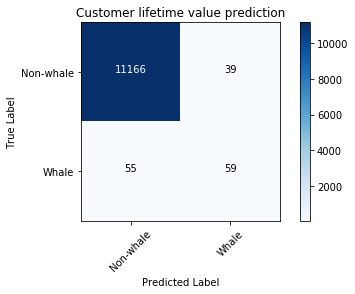

In [82]:
cm = confusion_matrix(y_test, y_pred_smote)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [86]:
# f1 score with SMOTE
f1_score(y_test, y_pred_smote, average=None)[1]

0.55660377358490576

In [87]:
top_features = utils.feature_importances(clf_smote, features_encoded, n=20)
top_features

1: Feature: initial_deposit_amount, 0.291
2: Feature: SUM(transactions.conversion_to_sb), 0.096
3: Feature: MAX(transactions.number_of_sessions), 0.069
4: Feature: STD(transactions.conversion_to_sb), 0.061
5: Feature: nationality = unknown, 0.057
6: Feature: gender = unknown, 0.057
7: Feature: gender = MALE, 0.052
8: Feature: COUNT(transactions), 0.049
9: Feature: STD(transactions.number_of_sessions), 0.044
10: Feature: MEAN(transactions.conversion_to_sb), 0.043
11: Feature: MAX(transactions.conversion_to_sb), 0.031
12: Feature: MODE(transactions.account_status) = SERIOUS_BUX, 0.028
13: Feature: NUM_UNIQUE(transactions.social_status), 0.020
14: Feature: nationality = AT, 0.010
15: Feature: MODE(transactions.account_status) = FUN_BUX, 0.007
16: Feature: MEAN(transactions.number_of_sessions), 0.006
17: Feature: NUM_UNIQUE(transactions.account_status), 0.004
18: Feature: nationality = DE, 0.004
19: Feature: network = Facebook Installs, 0.004
20: Feature: country_cd = AT, 0.003


[<Feature: initial_deposit_amount>,
 <Feature: SUM(transactions.conversion_to_sb)>,
 <Feature: MAX(transactions.number_of_sessions)>,
 <Feature: STD(transactions.conversion_to_sb)>,
 <Feature: nationality = unknown>,
 <Feature: gender = unknown>,
 <Feature: gender = MALE>,
 <Feature: COUNT(transactions)>,
 <Feature: STD(transactions.number_of_sessions)>,
 <Feature: MEAN(transactions.conversion_to_sb)>,
 <Feature: MAX(transactions.conversion_to_sb)>,
 <Feature: MODE(transactions.account_status) = SERIOUS_BUX>,
 <Feature: NUM_UNIQUE(transactions.social_status)>,
 <Feature: nationality = AT>,
 <Feature: MODE(transactions.account_status) = FUN_BUX>,
 <Feature: MEAN(transactions.number_of_sessions)>,
 <Feature: NUM_UNIQUE(transactions.account_status)>,
 <Feature: nationality = DE>,
 <Feature: network = Facebook Installs>,
 <Feature: country_cd = AT>]

## Regular (no over/undersampling)

In [88]:
# GradientBoostingRegressor(verbose=True)
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [89]:
%%time

clf.fit(X_train, y_train)

CPU times: user 1min 4s, sys: 299 ms, total: 1min 4s
Wall time: 23.3 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [90]:
y_pred = clf.predict(X_test)

In [91]:
clf.score(X_test, y_test)

0.99213711458609422

In [92]:
precision_recall_fscore_support(y_test, y_pred, average='weighted')

(0.9908062736812574, 0.99213711458609422, 0.99101325275267171, None)

In [93]:
# random forest classifer, 5-fold cross-validation
# clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf, X=X, y=y, scoring='f1', verbose=True, cv=5)
"F1 %.2f +/- %.2f" % (scores.mean(), scores.std())

[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  1.9min finished


'F1 0.55 +/- 0.04'

In [94]:
# get F1 score for each of the folds
scores

array([ 0.55952381,  0.53551913,  0.57608696,  0.49411765,  0.60869565])

In [95]:
cm = confusion_matrix(y_test, y_pred)

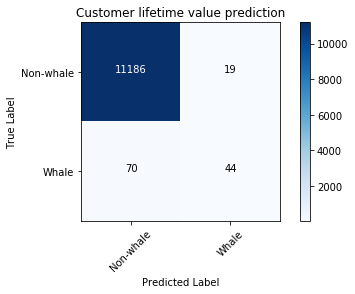

In [96]:
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

In [97]:
from sklearn.metrics import f1_score
f1_score(y_test, y_pred, average=None)

array([ 0.99603758,  0.49717514])

In [98]:
top_features = utils.feature_importances(clf, features_encoded, n=20)

1: Feature: initial_deposit_amount, 0.106
2: Feature: SUM(transactions.number_of_sessions), 0.068
3: Feature: MEAN(transactions.number_of_sessions), 0.059
4: Feature: SUM(transactions.total_session_duration), 0.051
5: Feature: STD(transactions.number_of_sessions), 0.040
6: Feature: STD(transactions.conversion_to_sb), 0.040
7: Feature: MEAN(transactions.conversion_to_sb), 0.036
8: Feature: MEAN(transactions.total_session_duration), 0.036
9: Feature: MAX(transactions.number_of_sessions), 0.034
10: Feature: MAX(transactions.total_session_duration), 0.030
11: Feature: STD(transactions.total_session_duration), 0.030
12: Feature: MAX(transactions.conversion_to_sb), 0.028
13: Feature: SUM(transactions.conversion_to_sb), 0.028
14: Feature: MODE(transactions.account_status) = SERIOUS_BUX, 0.023
15: Feature: bux_account_created_day, 0.021
16: Feature: MAX(transactions.day_of_year), 0.021
17: Feature: SUM(transactions.day_of_year), 0.020
18: Feature: MEAN(transactions.day_of_year), 0.020
19: Feat

In [99]:
ft.save_features(top_features, "top_features")

### Retrain the classifier on top 20 features

In [100]:
# load in the features from before
top_features = ft.load_features("top_features", es)

In [101]:
%%time

fm = ft.calculate_feature_matrix(top_features,
                                 entityset=es,
                                 # cutoff_time = label_times,
                                 cutoff_time_in_index=True,
                                 verbose=False)

CPU times: user 21min 57s, sys: 2.72 s, total: 21min 59s
Wall time: 22min 7s


## Classification

In [102]:
X = fm.reset_index().merge(CurCV[['user_id', 'whale']])
X = X.fillna(0)
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("whale")

In [103]:
# top 20 features
len(X.columns)

20

In [104]:
y.value_counts()

0    56027
1      566
Name: whale, dtype: int64

In [105]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [106]:
# GradientBoostingRegressor(verbose=True)
clf = RandomForestClassifier(n_estimators=400, n_jobs=-1)

In [107]:
%%time

clf.fit(X_train, y_train)

CPU times: user 1min 13s, sys: 299 ms, total: 1min 14s
Wall time: 25.1 s


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=400, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [108]:
y_pred = clf.predict(X_test)

In [109]:
precision, recall, fscore, support = score(y_test, y_pred)

print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [ 0.99431077  0.72115385]
recall: [ 0.99827453  0.43859649]
fscore: [ 0.99628871  0.54545455]
support: [16807   171]


In [110]:
%%time

clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf_cv, X=X, y=y, scoring='f1', verbose=True, cv=5)
print("F1 score %.2f +/- %.2f" % (scores.mean(), scores.std()))

F1 score 0.57 +/- 0.01
CPU times: user 7min 14s, sys: 2.08 s, total: 7min 16s
Wall time: 2min 13s


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [ ]:
scores

In [111]:
clf_cv = RandomForestClassifier(n_estimators=400, n_jobs=-1)
scores = cross_val_score(estimator=clf_cv, X=X, y=y, scoring='precision', verbose=True, cv=5)
print("Precision score %.2f +/- %.2f" % (scores.mean(), scores.std()))

F1 score 0.74 +/- 0.03


[Parallel(n_jobs=1)]: Done   5 out of   5 | elapsed:  2.2min finished


In [116]:
scores

array([ 0.796875  ,  0.72222222,  0.72151899,  0.72463768,  0.75362319])

In [117]:
# percentage of whales in each cross-validation set

lim_1 = int(len(y)/5)
lim_2 = int(len(y)/5)*2
lim_3 = int(len(y)/5)*3
lim_4 = int(len(y)/5)*4
lim_5 = int(len(y))


y[0:lim_1].value_counts()[1] / len(y[0:lim_1])*100, y[lim_1:lim_2].value_counts()[1] / len(y[lim_1:lim_2])*100, y[lim_2:lim_3].value_counts()[1] / len(y[lim_2:lim_3])*100, y[lim_3:lim_4].value_counts()[1] / len(y[lim_3:lim_4])*100, y[lim_4:lim_5].value_counts()[1] / len(y[lim_4:lim_5])*100

(0.99840961300583142,
 0.85704188019084648,
 0.99840961300583142,
 1.1309418625198799,
 1.015811324087978)

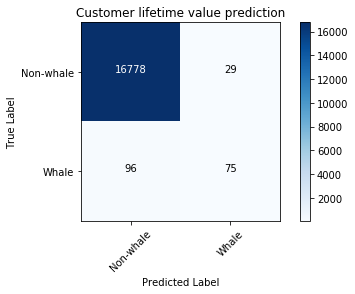

In [118]:
cm = confusion_matrix(y_test, y_pred)
utils.plot_confusion_matrix(cm, ['Non-whale', 'Whale'], title='Customer lifetime value prediction')

Text(0.5,1,'2-class Precision-Recall curve: AP=0.32')

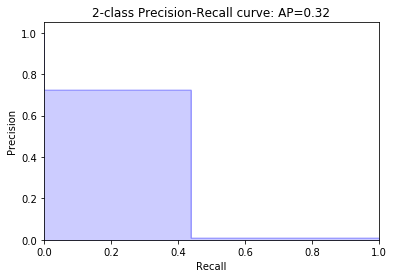

In [115]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score


y_pred_proba = clf.predict_proba(X_test)
average_precision = average_precision_score(y_test, y_pred)
pr, re, _ = precision_recall_curve(y_test,y_pred,pos_label=1)


plt.step(re, pr, color='b', alpha=0.2,
         where='post')
plt.fill_between(re, pr, step='post', alpha=0.2,
                 color='b')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('2-class Precision-Recall curve: AP={0:0.2f}'.format(
          average_precision))

In [ ]:
clf_cv.decision_path(X_test)

### 30% test set (Feb 17 cohort)

![title](img/30% test set  - Feb 17 cohort.png)

## 40% test set (Feb 17 cohort)

![title](img/40% test set - Feb 17 cohort.png)

## 30% test set (Feb 17 cohort, 30k users sample)
![title](img/confusion_matrix - 30.000 users - first pipeline.png)

## Regression

In [559]:
X = fm.reset_index().merge(CurCV[['user_id', 'curcv']])
X = X.fillna(0)
X.drop(["user_id", "time"], axis=1, inplace=True)
y = X.pop("curcv")

In [560]:
len(X.columns)

20

In [561]:
# average customer value
y.mean()

6.679892666666674

In [562]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [563]:
y_train.describe()

count    10500.000000
mean         5.319653
std        113.743554
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max       6210.170000
Name: curcv, dtype: float64

In [564]:
y_test.describe()

count     4500.000000
mean         9.853784
std        240.957293
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max      12597.100000
Name: curcv, dtype: float64

In [565]:
regr = RandomForestRegressor(max_depth=2, random_state=0)

In [566]:
%%time


regr.fit(X_train, y_train)

CPU times: user 636 ms, sys: 0 ns, total: 636 ms
Wall time: 643 ms


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=2,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=0, verbose=0, warm_start=False)

In [567]:
utils.feature_importances(regr, features_encoded, n=20)

1: Feature: trading_experience = NONE, 0.560
2: Feature: trading_experience = EXPERT, 0.134
3: Feature: gender = unknown, 0.087
4: Feature: nationality = IT, 0.081
5: Feature: nationality = AT, 0.055
6: Feature: trading_experience = unknown, 0.043
7: Feature: nationality = PL, 0.040
8: Feature: trading_experience = SOME, 0.000
9: Feature: gender = MALE, 0.000
10: Feature: gender = FEMALE, 0.000
11: Feature: title = Rookie Trader, 0.000
12: Feature: title = Experienced Trader, 0.000
13: Feature: title = Pro Trader, 0.000
14: Feature: title = unknown, 0.000
15: Feature: nationality = DE, 0.000
16: Feature: nationality = GB, 0.000
17: Feature: nationality = TR, 0.000
18: Feature: nationality = DK, 0.000
19: Feature: nationality = RO, 0.000
20: Feature: nationality = GR, 0.000


[<Feature: trading_experience = NONE>,
 <Feature: trading_experience = EXPERT>,
 <Feature: gender = unknown>,
 <Feature: nationality = IT>,
 <Feature: nationality = AT>,
 <Feature: trading_experience = unknown>,
 <Feature: nationality = PL>,
 <Feature: trading_experience = SOME>,
 <Feature: gender = MALE>,
 <Feature: gender = FEMALE>,
 <Feature: title = Rookie Trader>,
 <Feature: title = Experienced Trader>,
 <Feature: title = Pro Trader>,
 <Feature: title = unknown>,
 <Feature: nationality = DE>,
 <Feature: nationality = GB>,
 <Feature: nationality = TR>,
 <Feature: nationality = DK>,
 <Feature: nationality = RO>,
 <Feature: nationality = GR>]

In [568]:
y_pred = regr.predict(X_test)

In [569]:
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error

In [570]:
y_test.head()

11499    0.0
6475     0.0
13167    0.0
862      0.0
5970     0.0
Name: curcv, dtype: float64

In [571]:
r2_reg = r2_score(y_test, y_pred).round(3)
r2_reg

0.107

In [572]:
print(mean_absolute_error(y_test, y_pred))
print(mean_squared_error(y_test, y_pred))
print(np.sqrt(mean_squared_error(y_test, y_pred)))

11.7074452488
51848.5119035
227.702683128


In [573]:
test_set_pred = sum(y_pred)
test_set_true = sum(y_test)

test_set_pred, test_set_true

(32763.885806112103, 44342.029999999984)

In [574]:
test_set_benchmark = len(y_test) * CurCV['curcv'].mean()

test_set_benchmark, test_set_true

(31986.982499999987, 44342.029999999984)

In [575]:
y_benchmark = [CurCV['curcv'].mean() for i in range(0,len(y_test))]

In [576]:
print(mean_absolute_error(y_test, y_benchmark))
print(mean_squared_error(y_test, y_benchmark))
print(np.sqrt(mean_squared_error(y_test, y_benchmark)))

16.5399014526
58055.0530432
240.946162126
